In [ ]:
%pip install pydantic opstrat

In [42]:
import pandas as pd

# Black Scholes Model

The $Black Scholes$ model was published in 1973 for non-dividend paying stocks and since then the model has created a revolution in quantitative finance and opened up derivatives pricing paradigm. Black Scholes model is based on number of assumptions about how financial markets operate and those are:

- Arbitrage Free Markets
- Frictionless and Continuous Markets
- Risk Free Rates
- Log-normally Distributed Price Movements
- Constant Volatility

These assumptions maynot hold true in reality, but are not particularly limiting. The generalized Black Scholes framework have been extended to price derivaties of other asset classes such as Black 76 (Commodity Futures) and Garman-Kohlhagen (FX Futures) that are currently used in derivative pricing and risk management.

### Black Scholes Formula

The Black–Scholes equation describes the price of the option over time as

$$\frac{\partial V}{\partial t} + \frac{1}{2}\sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} + r S \frac{\partial V}{\partial S} - r V = 0$$

Solving the above equation, we know that the value of a call option for a non-dividend paying stock is:


$$C = SN(d_1) - Ke^{-rt}N(d_2)$$

And the corresponding put option price is:

$$ P = Ke^{-rt}N(-d_2) - SN(-d_1)$$

Where,

$$d_1 = \frac{1}{\sigma\sqrt{t}}\bigg[ln\bigg(\frac{S}{K}\bigg)+\bigg(r + \frac{\sigma^{2}}{2}\bigg)t\bigg]$$

&nbsp;

$$d_2 = d_1 - \sigma\sqrt{t}$$

&nbsp;

$$N(x) = \frac{1}{\sqrt{2\pi}}\int_{-\infty}^{x} e^{-\frac{1}{2}x^{2}}$$

- $S$
  is the spot price of the underlying asset
- $K$
 is the strike price
- $r$
 is the annualized continuous compounded risk free rate
- $\sigma$
 is the volatility of returns of the underlying asset
- t
 is time to maturity (expressed in years)
- N(x)
 is the standard normal cumulative distribution

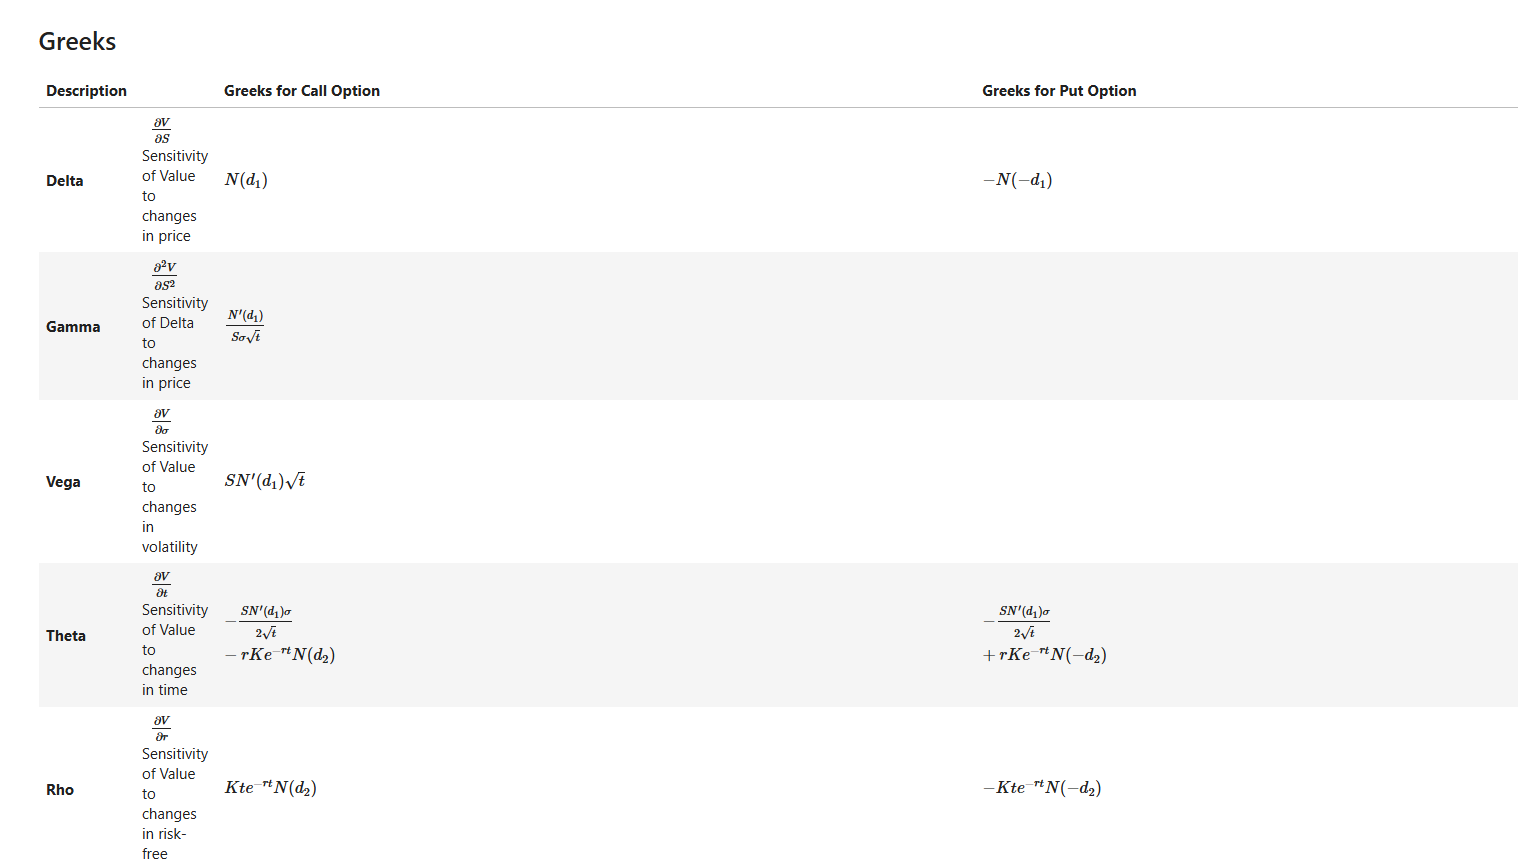

In [2]:
from pydantic import BaseModel, Field, computed_field
from typing import Literal
import numpy as np
from scipy.stats import norm
from datetime import datetime

# Plotting
import matplotlib.pyplot as plt
from tabulate import tabulate

# Option Strategy plotting
import opstrat as op
import yfinance as yf

In [82]:
# Option Object using pydantic
class OptionInputs(BaseModel):
    option_type: Literal["call", "put"]
    spot_price: float = Field(gt=0, description="Current price of the underlying asset")
    strike_price: float = Field(gt=0, description="Strike price of the option")
    time_to_expiry: float = Field(gt=0, description="Time to expiration in years")
    risk_free_rate: float = Field(ge=0, le=1, description="Risk-free interest rate")
    volatility: float = Field(gt=0, description="Volatility of the underlying asset")
        
class BlackScholesModel(BaseModel):
    inputs: OptionInputs
        
    @computed_field
    def d1(self) -> float:
        return (np.log(self.inputs.spot_price / self.inputs.strike_price) + 
                (self.inputs.risk_free_rate + 0.5 * self.inputs.volatility**2) * self.inputs.time_to_expiry) / \
               (self.inputs.volatility * np.sqrt(self.inputs.time_to_expiry))
        
    @computed_field
    def d2(self) -> float:
        return(self.d1 - self.inputs.volatility * np.sqrt(self.inputs.time_to_expiry))
    
    @computed_field
    def price(self) -> float:
        if self.inputs.option_type == "call":
            return self.inputs.spot_price * norm.cdf(self.d1) - self.inputs.strike_price * np.exp((-self.inputs.risk_free_rate)*self.inputs.time_to_expiry)*norm.cdf(self.d2)
        else:
            return self.inputs.strike_price * np.exp((-self.inputs.risk_free_rate)*self.inputs.time_to_expiry)*norm.cdf(-self.d2)-self.inputs.spot_price * norm.cdf(-self.d1)

        
    @computed_field
    def delta(self) -> float:
        if self.inputs.option_type == "call":
            return norm.cdf(self.d1)
        else:
            return norm.cdf(self.d1) - 1
        
    @computed_field
    def gamma(self) -> float:
        return norm.pdf(self.d1)/(self.inputs.spot_price*self.inputs.volatility*np.sqrt(self.inputs.time_to_expiry))
    
    @computed_field
    def vega(self) -> float:
        return self.inputs.spot_price * norm.pdf(self.d1) * np.sqrt(self.inputs.time_to_expiry) / 100
    
    @computed_field
    def theta(self) -> float:
        common = -(self.inputs.spot_price * norm.pdf(self.d1) * self.inputs.volatility) / (2 * np.sqrt(self.inputs.time_to_expiry))
        if self.inputs.option_type == "call":
            return (common - self.inputs.risk_free_rate * self.inputs.strike_price * 
                    np.exp(-self.inputs.risk_free_rate * self.inputs.time_to_expiry) * norm.cdf(self.d2)) / 365
        else:  # put option
            return (common + self.inputs.risk_free_rate * self.inputs.strike_price * 
                    np.exp(-self.inputs.risk_free_rate * self.inputs.time_to_expiry) * norm.cdf(-self.d2)) / 365
    
    @computed_field
    def rho(self) -> float:
        if self.inputs.option_type == "call":
            return self.inputs.strike_price * self.inputs.time_to_expiry * np.exp(-self.inputs.risk_free_rate * self.inputs.time_to_expiry) * norm.cdf(self.d2) / 100
        else:  # put option
            return -self.inputs.strike_price * self.inputs.time_to_expiry * np.exp(-self.inputs.risk_free_rate * self.inputs.time_to_expiry) * norm.cdf(-self.d2) / 100

In [83]:
# Get the inputs for a option
call_option_inputs = OptionInputs(
    option_type="call",
    spot_price=100,
    strike_price=100,
    time_to_expiry=1,
    risk_free_rate=0.05,
    volatility=0.2
)

# Create a copy of the inputs with the option_type set to "put"
put_option_inputs = call_option_inputs.model_copy(update={"option_type": "put"})

# Create a BlackScholesModel object with the inputs
call_option = BlackScholesModel(inputs=call_option_inputs)
put_option = BlackScholesModel(inputs=put_option_inputs)


header = ['Option Type', 'Option Price', 'Delta', 'Gamma', 'Theta', 'Vega', 'Rho']
table = [
    [call_option_inputs.option_type, call_option.price, call_option.delta, call_option.gamma, call_option.theta, call_option.vega, call_option.rho],
    [put_option_inputs.option_type, put_option.price, put_option.delta, put_option.gamma, put_option.theta, put_option.vega, put_option.rho]
]

# Print the call option table
print(tabulate(table,header))

Option Type      Option Price      Delta     Gamma        Theta     Vega        Rho
-------------  --------------  ---------  --------  -----------  -------  ---------
call                 10.4506    0.636831  0.018762  -0.0175727   0.37524   0.532325
put                   5.57353  -0.363169  0.018762  -0.00454214  0.37524  -0.418905


In [63]:
#this is for my understanding

import numpy as np
from scipy.stats import norm

def black_scholes_merton(S, K, T, r, sigma, option_type='call'):
    

    # Calculate d1 and d2
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    # Calculate call and put prices
    if option_type == 'call':
        option_price = (S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2))
    elif option_type == 'put':
        option_price = (K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1))
    else:
        raise ValueError("option_type must be 'call' or 'put'")
    
    return option_price

# Example usage
S = 100         # Current stock price
K = 100         # Strike price
T = 1           # Time to expiration (1 year)
r = 0.05        # Risk-free interest rate (5%)
sigma = 0.2     # Volatility (20%)

call_price = black_scholes_merton(S, K, T, r, sigma, option_type='call')
put_price = black_scholes_merton(S, K, T, r, sigma, option_type='put')

print(f"Call Option Price: {call_price}")
print(f"Put Option Price: {put_price}")

Call Option Price: 10.450583572185565
Put Option Price: 5.573526022256971


## Option Payoff visualisation

Traders construct option strategies ranging from buying or selling a single option to very complex ones that involve multiple simultaneous option positions. Option payoff diagrams are profit and loss charts that show the risk/reward profile of an option or combination of options. As option probability can be complex to understand, payoff diagrams gives an insight into the risk/reward for the trading strategy. Opstrat is a package for visualizing these Option payoffs.

### Long Call option

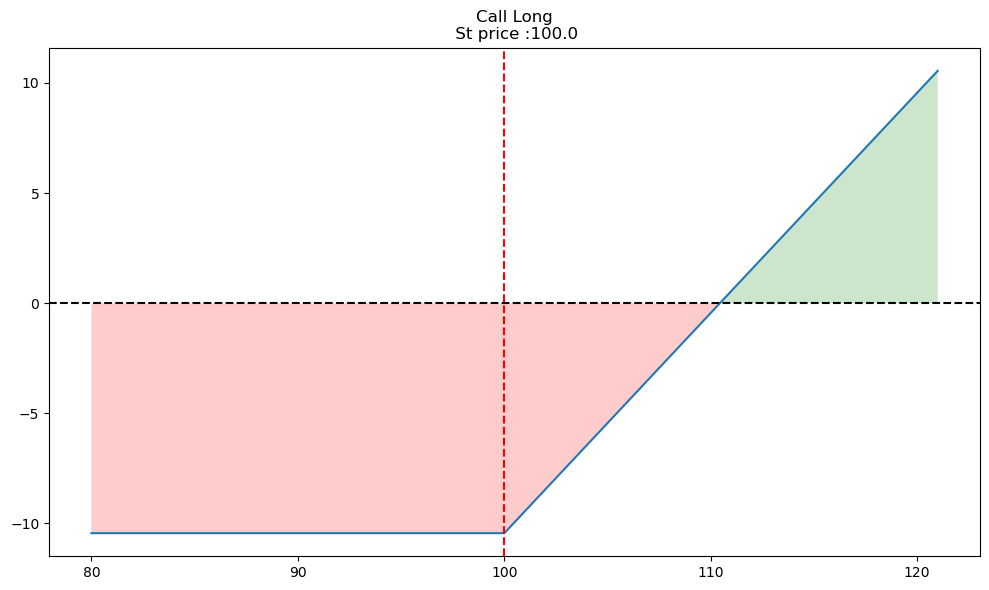

In [64]:
#Single plotter
op.single_plotter(spot=call_option_inputs.spot_price, strike=call_option_inputs.strike_price, op_type = 'c', tr_type='b', op_pr = call_option.price, spot_range=20)

## Short Straddle

A short straddle is an options trading strategy that involves selling a call and a put option of the same underlying stock, strike and expiration date. The strategy is designed to profit from the difference in the prices of the two options. The payoff diagram for this strategy can be plotted using the multi_plotter() function. This function will plot each individual payoff diagrams and the resultant payoff diagram. The particulars of each option has to be provided as a list of dictionaries.

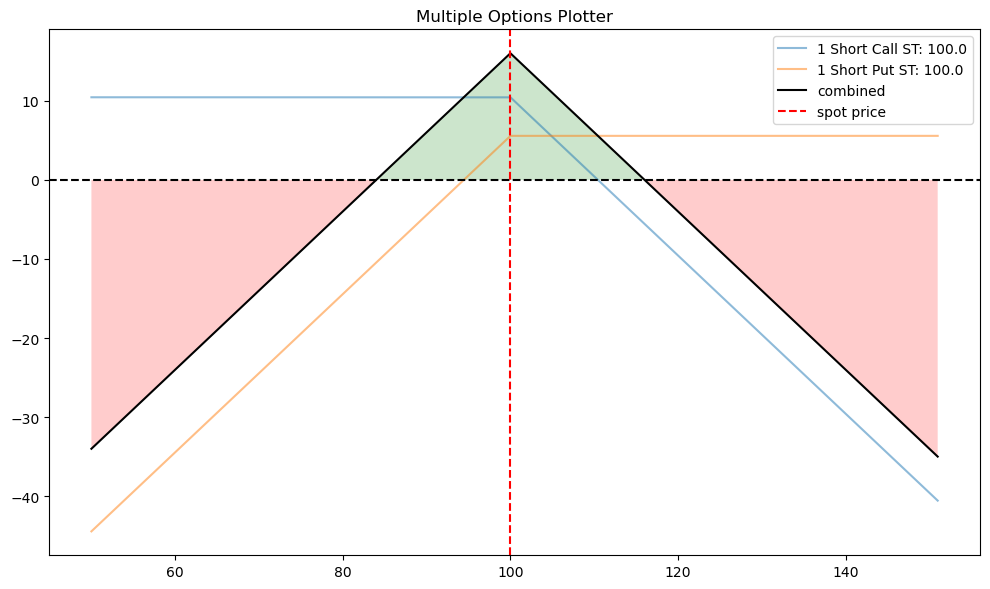

In [65]:
leg1 = BlackScholesModel(inputs=OptionInputs(option_type="call", spot_price=100, strike_price=100, time_to_expiry=1,risk_free_rate=0.05,volatility=0.2))
leg2 = BlackScholesModel(inputs=OptionInputs(option_type="put", spot_price=100, strike_price=100, time_to_expiry=1,risk_free_rate=0.05,volatility=0.2))

# The particulars of each option has to be provided as a list of dictionaries.
op_1 = {'op_type': 'c', 'strike':leg1.inputs.strike_price, 'tr_type': 's', 'op_pr': leg1.price}
op_2 = {'op_type': 'p', 'strike':leg2.inputs.strike_price, 'tr_type': 's', 'op_pr': leg2.price}
op_list = [op_1, op_2]

# Multi-plotter
op.multi_plotter(spot=leg1.inputs.spot_price, spot_range=50, op_list=op_list)

## Short Strangle

A short strangle is an options trading strategy that involves selling a call and a put option of the same underlying stock and expiration date. The strategy is designed to profit from the difference in the prices of the two options. The payoff diagram for this strategy can be plotted using the multi_plotter() function. This function will plot each individual payoff diagrams and the resultant payoff diagram. The particulars of each option has to be provided as a list of dictionaries.

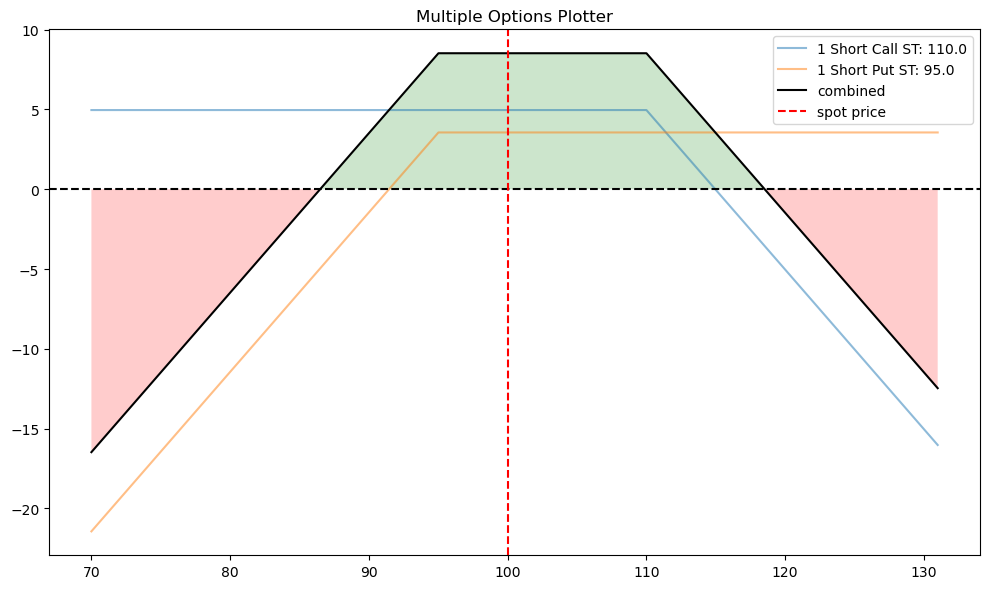

In [66]:
leg1 = BlackScholesModel(inputs=OptionInputs(option_type="call",spot_price=100,strike_price=110,time_to_expiry=1,risk_free_rate=0.05,volatility=0.2))
leg2 = BlackScholesModel(inputs=OptionInputs(option_type="put",spot_price=100,strike_price=95,time_to_expiry=1,risk_free_rate=0.05,volatility=0.2))

# The particulars of each option has to be provided as a list of dictionaries.
op_1 = {'op_type': 'c', 'strike':leg1.inputs.strike_price, 'tr_type': 's', 'op_pr': leg1.price}
op_2 = {'op_type': 'p', 'strike':leg2.inputs.strike_price, 'tr_type': 's', 'op_pr': leg2.price}
op_list = [op_1, op_2]

# Multi-plotter
op.multi_plotter(spot=leg1.inputs.spot_price, spot_range=30, op_list=op_list)

In [67]:
leg1.price + leg2.price

8.525095828119156

## Iron Condor

An iron condor is an options strategy consisting of two puts (one long and one short) and two calls (one long and one short), and four strike prices, all with the same expiration date. The strategy is designed to profit from the difference in the option prices. The payoff diagram for this strategy can be plotted using the multi_plotter() function. This function will plot each individual payoff diagrams and the resultant payoff diagram. The particulars of each option has to be provided as a list of dictionaries.

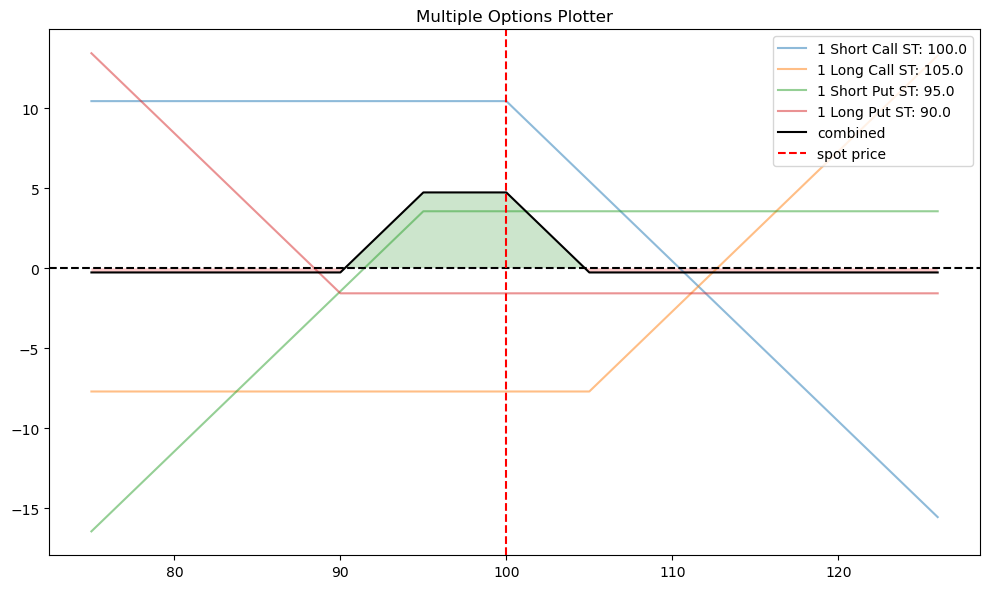

In [68]:
leg1 = BlackScholesModel(inputs = OptionInputs(option_type="call", spot_price=100, strike_price=100, time_to_expiry=1, risk_free_rate=0.05, volatility=0.2))
leg2 = BlackScholesModel(inputs = OptionInputs(option_type="call", spot_price=100, strike_price=105, time_to_expiry=1, risk_free_rate=0.05, volatility=0.2))
leg3 = BlackScholesModel(inputs = OptionInputs(option_type="put", spot_price=100, strike_price=95, time_to_expiry=1, risk_free_rate=0.05, volatility=0.2))
leg4 = BlackScholesModel(inputs = OptionInputs(option_type="put", spot_price=100, strike_price=90, time_to_expiry=1, risk_free_rate=0.05, volatility=0.2))

# The particulars of each option has to be provided as a list of dictionaries.
op_1 = {'op_type': 'c', 'strike':leg1.inputs.strike_price, 'tr_type': 's', 'op_pr': leg1.price}
op_2 = {'op_type': 'c', 'strike':leg2.inputs.strike_price, 'tr_type': 'b', 'op_pr': leg2.price}
op_3 = {'op_type': 'p', 'strike':leg3.inputs.strike_price, 'tr_type': 's', 'op_pr': leg3.price} 
op_4 = {'op_type': 'p', 'strike':leg4.inputs.strike_price, 'tr_type': 'b', 'op_pr': leg4.price}

op_list = [op_1, op_2, op_3, op_4]

# Multi-plotter
op.multi_plotter(spot=leg1.inputs.spot_price, spot_range=25, op_list=op_list)

### BSM model for SPY oprion prices

In [84]:
# Get SPY option chain
spy = yf.Ticker('SPY')
options = spy.option_chain('2024-09-30')

In [85]:
dte = (datetime(2024, 9, 30) - datetime.today()).days/365
spot = 532.905; strike = 533; rate = 0.00; dte = dte; vol = 0.2107

spy_opt =BlackScholesModel(inputs=OptionInputs(option_type="call",spot_price=spot,strike_price=strike,time_to_expiry=dte,risk_free_rate=rate,volatility=vol))
print(f'Option Price of SPY240930C00533000 with BS Model is {spy_opt.price:0.4f}')

Option Price of SPY240930C00533000 with BS Model is 13.8225


In [86]:
options.calls.head()

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,SPY240930C00300000,2024-08-21 15:57:28+00:00,300.0,260.19,262.74,263.76,0.0,0.0,1.0,85,0.990723,True,REGULAR,USD
1,SPY240930C00305000,2024-06-18 17:37:53+00:00,305.0,246.47,250.43,251.63,0.0,0.0,162.0,122,0.000010,True,REGULAR,USD
2,SPY240930C00310000,2024-06-21 13:47:49+00:00,310.0,238.47,241.46,242.31,0.0,0.0,2.0,67,0.000010,True,REGULAR,USD
3,SPY240930C00315000,2024-06-18 18:38:41+00:00,315.0,236.02,240.67,241.88,0.0,0.0,104.0,63,0.000010,True,REGULAR,USD
4,SPY240930C00320000,2024-06-18 16:16:22+00:00,320.0,231.22,235.76,236.94,0.0,0.0,6.0,8,0.000010,True,REGULAR,USD


In [115]:
df = options.puts[(options.puts['strike']>=450) & (options.puts['strike']<=600)]
df.reset_index(drop=True, inplace=True)

# Dataframe manipulation with selected fields
df = pd.DataFrame({'Strike': df['strike'], 
                   'Price': df['lastPrice'], 
                   'ImpVol': df['impliedVolatility']})

# Derive greeks and assign to dataframe as columns
df['Delta'] = df['Gamma'] = df['Vega'] = df['Theta'] = 0.

for i in range(len(df)):

    option = BlackScholesModel(inputs=OptionInputs(option_type="call",spot_price=spot,strike_price=df['Strike'].iloc[i],time_to_expiry=dte,risk_free_rate=rate,volatility=df['ImpVol'].iloc[i]))
    
    df['Delta'].iloc[i] = option.delta
    df['Gamma'].iloc[i] = option.gamma
    df['Vega'].iloc[i] = option.vega
    df['Theta'].iloc[i] = option.theta

# Check output
df.head(2)

,Strike,Price,ImpVol,Delta,Gamma,Vega,Theta
0,450.0,0.37,0.337653,0.952493,0.001777,0.163379,-0.078808
1,451.0,0.43,0.334723,0.951724,0.001816,0.165492,-0.079134


## Data Visualisation

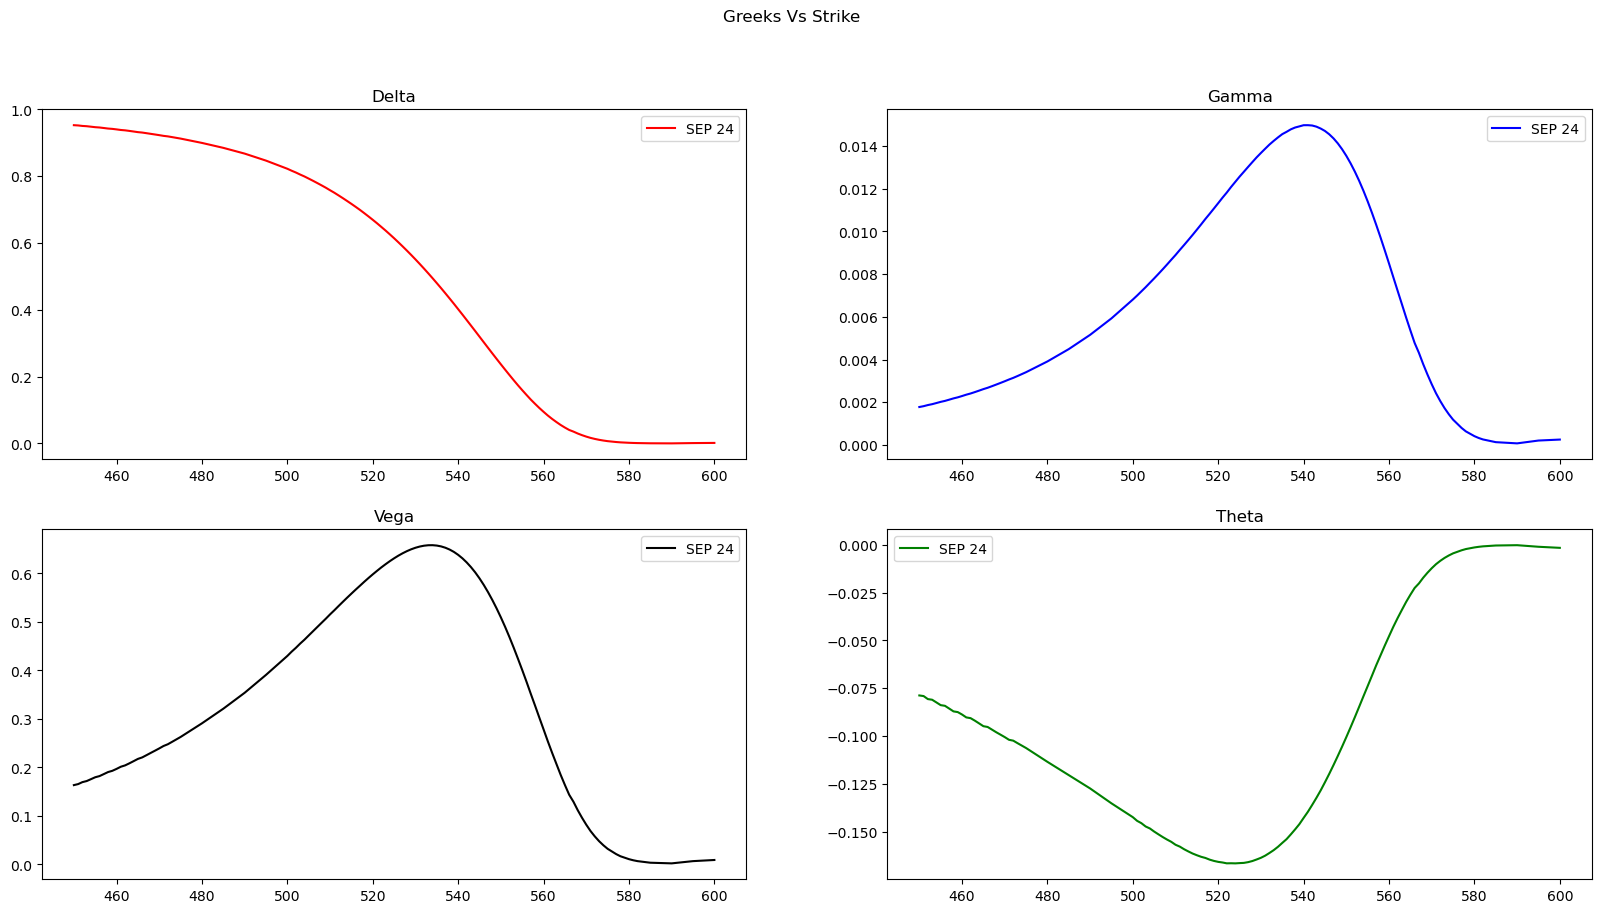

In [117]:
# Plot graph iteratively
fig, ax = plt.subplots(2,2, figsize=(20,10))

ax[0,0].plot(df['Strike'], df['Delta'], color='r', label='SEP 24')
ax[0,1].plot(df['Strike'], df['Gamma'], color='b', label='SEP 24')
ax[1,0].plot(df['Strike'], df['Vega'],  color='k', label='SEP 24')
ax[1,1].plot(df['Strike'], df['Theta'], color='g', label='SEP 24')
    
# Set axis title
ax[0,0].set_title('Delta'), ax[0,1].set_title('Gamma'), ax[1,0].set_title('Vega'), ax[1,1].set_title('Theta')

# Define legend
ax[0,0].legend(), ax[0,1].legend(), ax[1,0].legend(), ax[1,1].legend()

# Set title
fig.suptitle('Greeks Vs Strike')

plt.show()